# Shap explanation of regressions

A good overview of shap values and visuals for regression models following [Explaining Scikit-learn models with SHAP](https://towardsdatascience.com/explaining-scikit-learn-models-with-shap-61daff21b12a) by Zolzaya Luvsandorj. This demo a regression question, while the next one on classification. 

In [4]:
import numpy as np
np.set_printoptions(formatter={'float':lambda x:"{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier)
import shap #v0.39.0
shap.initjs()

# Import sample data
diabetes = load_diabetes(as_frame=True)
X = diabetes['data'].iloc[:, :4] # Select first 4 columns
y = diabetes['target']
# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}\n")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
display(X_train.head())
# Train a simple model
# model = RandomForestRegressor(random_state=42)
import xgboost as xgb
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

Training features shape: (353, 4)
Training target shape: (353,)

Test features shape: (89, 4)
Test target shape: (89,)


,age,sex,bmi,bp
438,-0.006,0.051,-0.016,-0.068
232,0.013,0.051,0.000,-0.011
80,0.071,-0.045,0.012,0.043
46,-0.056,-0.045,-0.012,-0.033
381,-0.071,0.051,-0.089,-0.075


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [5]:
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 89

Sample shap value:
.values =
array([-9.7366, 4.1066, -23.3560, -33.6660], dtype=float32)

.base_values =
153.37714

.data =
array([0.0417, -0.0446, -0.0321, -0.0619])


The length of shap_test is 89 because it contains a record for each test instance. From looking at the first test record, we can see that there are three attributes:

◼ shap_test[0].base_values: Base value for target
◼ shap_test[0].data: Value for each feature
◼ shap_test[0].values: Shap value for each feature

## base_values

Base value (shap_test.base_values), also known as the expected value (explainer.expected_value), is the average target value in the training data. 

In [6]:
print(f"Expected value: {explainer.expected_value:.1f}") #explainer.expected_value[0] for RF regressor
print(f"Average target value (training data): {y_train.mean():.1f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.1f}")

Expected value: 153.4
Average target value (training data): 153.4
Base value: 153.4


## data

Next, shap_test.data contains the same values as X_test.

In [7]:
(shap_test.data == X_test).describe()

,age,sex,bmi,bp
count,89,89,89,89
unique,1,1,1,1
top,True,True,True,True
freq,89,89,89,89


In [8]:
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

,age,sex,bmi,bp
246,0.042,-0.045,-0.032,-0.062
425,-0.078,-0.045,-0.041,-0.081
293,-0.071,-0.045,0.093,0.013
31,-0.024,-0.045,-0.065,-0.081
359,0.038,0.051,0.006,0.032
...,...,...,...,...
277,-0.035,-0.045,-0.059,0.001
132,0.016,0.051,-0.021,-0.009
213,0.002,-0.045,-0.071,-0.023
286,-0.038,-0.045,-0.055,-0.078


## value

This one contains the shap value for each feature on each case.

In [9]:
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df.head()

,age,sex,bmi,bp
246,-9.737,4.107,-23.356,-33.666
425,9.859,9.647,-32.156,-3.150
293,-30.787,-1.822,72.160,-3.261
31,-4.646,-1.199,-25.021,-29.604
359,20.090,2.025,-17.839,-1.597


For each record, if we add shap values for each feature to the expected value, we will get the prediction:

In [10]:
np.isclose(model.predict(X_test), 
           explainer.expected_value + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

While shap package offer built-in visualizations, we can also create our own.

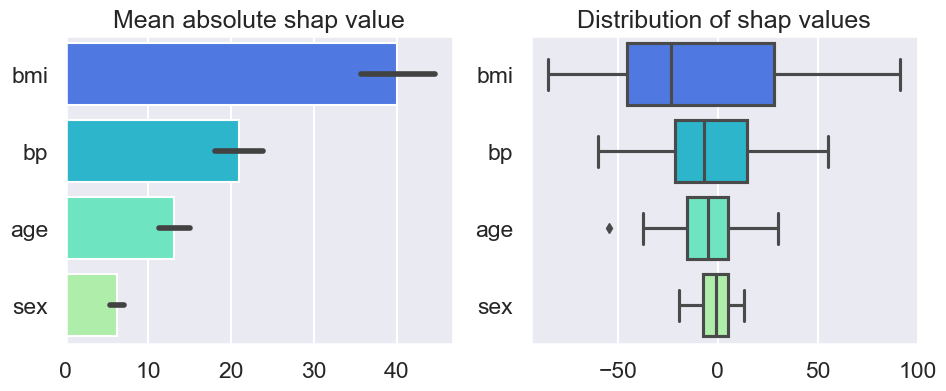

In [11]:
columns = shap_df.apply(np.abs).mean()\
                .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

# Shap Built-In Graphs

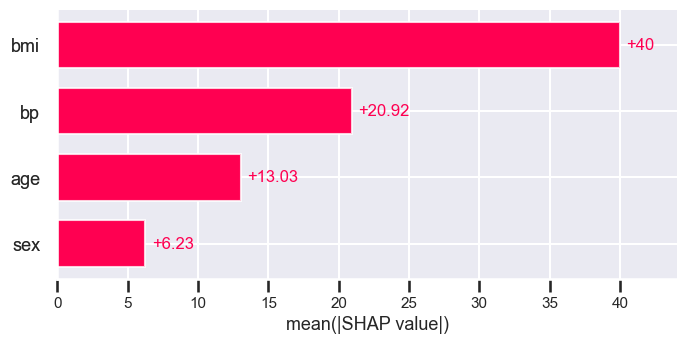

In [12]:
shap.plots.bar(shap_test)

In [13]:
from shap_func import get_SHAP_importance
shap_value_summary = get_SHAP_importance(model, X_test)
print(shap_value_summary)


  feature_name  mean_absolute_shap_value  max_shap_magnitude
2          bmi                    40.000              91.364
3           bp                    20.921              59.834
0          age                    13.030              54.275
1          sex                     6.227              19.372


### Global: Shap summary plot

Shap summary plot helps us see the direction of the relationship between features and the target.

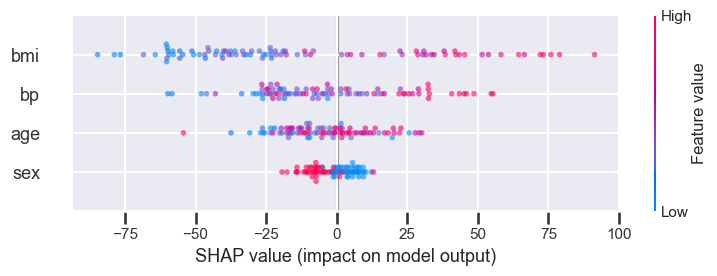

In [14]:
shap.summary_plot(shap_test, alpha = 0.6)

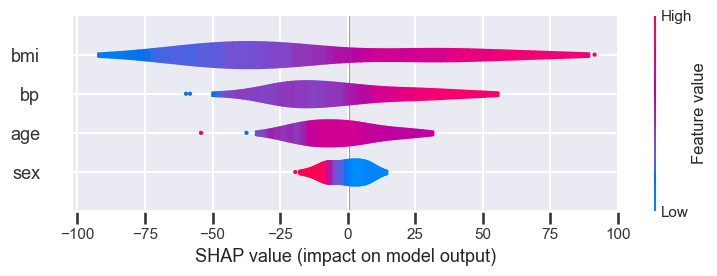

In [15]:
shap.summary_plot(shap_test, plot_type = 'violin')

### Global: Heatmap

According to [shap documentation](https://shap.readthedocs.io/en/latest/generated/shap.plots.heatmap.html). The `Heatmap` below is designed to show the population substructure of a dataset using supervised clustering and a heatmap. Supervised clustering involves clustering data points not by their original feature values but by their explanations.

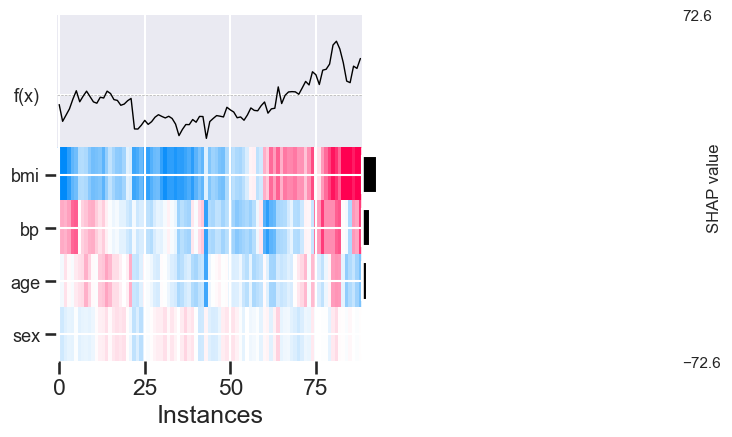

CPU times: total: 172 ms
Wall time: 156 ms


In [16]:
%%time
shap.plots.heatmap(shap_test)

### Global: Forceplot

This one is nicely interactive. But doesn't work in some environments, say on Databricks. 

In [17]:
%%time
shap.force_plot(explainer.expected_value, shap_test.values, 
                X_test)

CPU times: total: 0 ns
Wall time: 12.3 ms


### Local| Bar Plot 

This visual shows how a case' prediction differ from the base_value based on its features. 

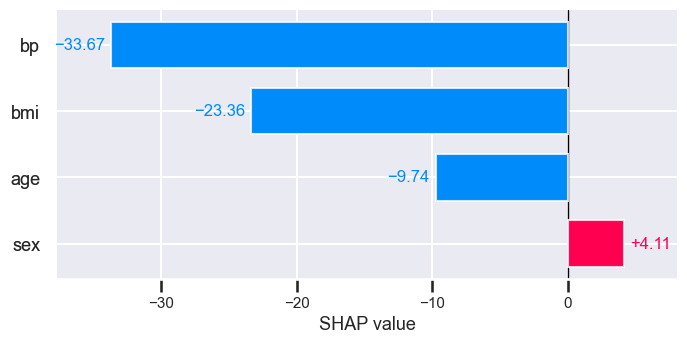

In [18]:
shap.plots.bar(shap_test[0])

### Local: Waterfall Plots

Waterfall plot offers similar info on feature contributions, but advance the storytelling by showing how a case go from base_value to predicted value. 

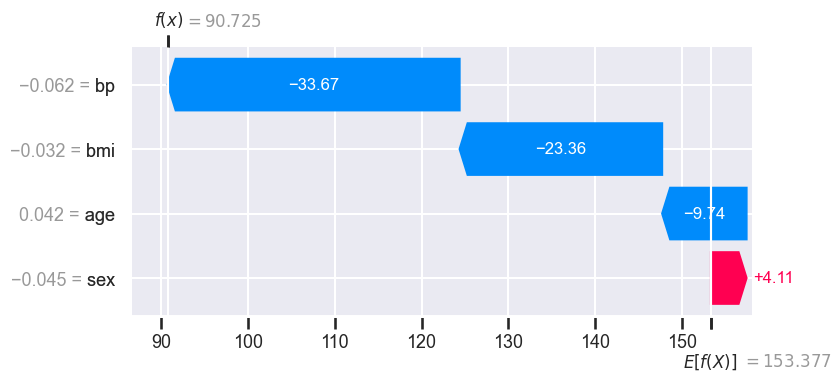

In [20]:
class WaterfallData():
    def __init__ (self, shap_test, index):
        self.values = shap_test[index].values
        self.base_values = shap_test[index].base_values
        self.data = shap_test[index].data
        self.feature_names = shap_test.feature_names
        self.display_data = None

shap.plots.waterfall(WaterfallData(shap_test, 0))
# shap.plots.waterfall(shap_test[0]) # for xgboost regressor use shap_test without transformation

### Local: Force Plot

Like waterfall plot, the force plot also offers a case' journey from base_value to the predicted value. But it is probably a bit harder to read if we have more features. 

In [ ]:
shap.plots.force(shap_test[0])
# shap.force_plot(shap_test[0]) # this works as well